In [25]:
from pathlib import Path

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.image as image
import matplotlib.dates as mdates

plt.rcParams["figure.figsize"] = [12.0, 6.0]

import okama as ok

pd.options.display.float_format = "{:,.5f}".format
np.set_printoptions(precision=5)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
ok.__version__

'1.3.2'

In [29]:
ok.symbols_in_namespace(namespace="MOEX")

,symbol,ticker,name,country,exchange,currency,type,isin
0,ABIO.MOEX,ABIO,ARTGEN,Russia,MOEX,RUB,Common Stock,
1,ABRD.MOEX,ABRD,Abrau Durso OAO,Russia,MOEX,RUB,Common Stock,RU000A0JS5T7
2,ACKO.MOEX,ACKO,Public joint-stock company Asko-Strakhovanie,Russia,MOEX,RUB,Common Stock,RU000A0JXS91
3,AFKS.MOEX,AFKS,AFK Sistema,Russia,MOEX,RUB,Common Stock,RU000A0DQZE3
4,AFLT.MOEX,AFLT,Aeroflot,Russia,MOEX,RUB,Common Stock,RU0009062285
...,...,...,...,...,...,...,...,...
345,YRSB.MOEX,YRSB,TNS Energo Yaroslavl PAO,Russia,MOEX,RUB,Common Stock,RU000A0D8760
346,YRSBP.MOEX,YRSBP,Public Joint Stock Company TNS Energo Yaroslav...,Russia,MOEX,RUB,Common Stock,
347,YUAN.MOEX,YUAN,YUAN Bonds ETF,Russia,MOEX,RUB,ETF,
348,ZILL.MOEX,ZILL,AMO ZIL PAO,Russia,MOEX,RUB,Common Stock,RU0009086193


## DCF

In [30]:
weights = [0.32, 0.31, 0.18, 0.19]
portf = ok.Portfolio(
    ["RGBITR.INDX", "RUCBTRNS.INDX", "MCFTR.INDX", "GC.COMM"],
    ccy="RUB",
    weights=weights,
    inflation=True,
    symbol="retirement_portf.PF",
    rebalancing_period="year",
    cashflow=200_000,
    initial_amount=39_000_000,
    discount_rate=None,
)
portf

C:\Users\Sergey\PycharmProjects\okama\okama\common\helpers\helpers.py:456: FutureWarning: The 'convention' keyword in DataFrame.resample is deprecated and will be removed in a future version. Explicitly cast PeriodIndex to DatetimeIndex before resampling instead.
  for x in ror.resample(rule=self.pandas_frequency, convention="start"):
C:\Users\Sergey\PycharmProjects\okama\okama\common\helpers\helpers.py:456: FutureWarning: Resampling with a PeriodIndex is deprecated. Cast index to DatetimeIndex before resampling instead.
  for x in ror.resample(rule=self.pandas_frequency, convention="start"):


symbol                                              retirement_portf.PF
assets                [RGBITR.INDX, RUCBTRNS.INDX, MCFTR.INDX, GC.COMM]
weights                                        [0.32, 0.31, 0.18, 0.19]
rebalancing_period                                                 year
currency                                                            RUB
inflation                                                      RUB.INFL
first_date                                                      2003-01
last_date                                                       2023-12
period_length                                        21 years, 0 months
dtype: object

In [31]:
portf.dcf.survival_period

C:\Users\Sergey\PycharmProjects\okama\okama\common\helpers\helpers.py:456: FutureWarning: The 'convention' keyword in DataFrame.resample is deprecated and will be removed in a future version. Explicitly cast PeriodIndex to DatetimeIndex before resampling instead.
  for x in ror.resample(rule=self.pandas_frequency, convention="start"):
C:\Users\Sergey\PycharmProjects\okama\okama\common\helpers\helpers.py:456: FutureWarning: Resampling with a PeriodIndex is deprecated. Cast index to DatetimeIndex before resampling instead.
  for x in ror.resample(rule=self.pandas_frequency, convention="start"):


21.0

In [32]:
portf.dcf.survival_date

Timestamp('2023-12-31 00:00:00')

## Rolling and expanding risk

In [13]:
al = ok.AssetList(['SPY.US', 'BND.US'])
al

assets             [SPY.US, BND.US]
currency                        USD
first_date                  2007-05
last_date                   2024-01
period_length    16 years, 9 months
inflation                  USD.INFL
dtype: object

<Axes: xlabel='date'>

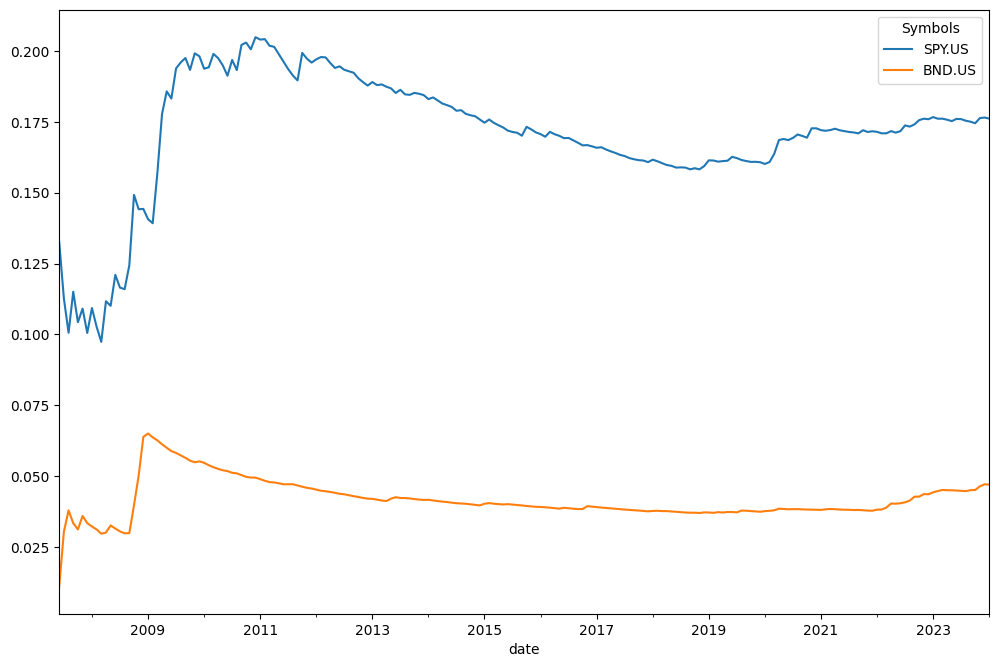

In [9]:
al.risk_annual.plot()

<Axes: xlabel='date'>

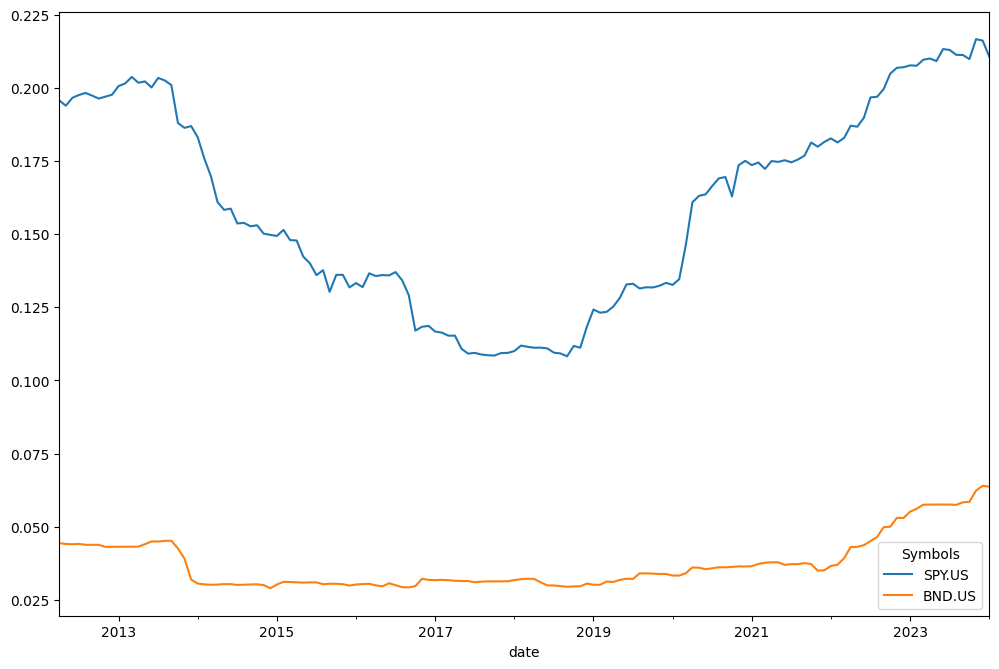

In [10]:
al.get_rolling_risk_annual(window=12*5).plot()

In [14]:
al.describe()

C:\Users\Sergey\PycharmProjects\okama\okama\asset.py:175: FutureWarning: Resampling with a PeriodIndex is deprecated. Cast index to DatetimeIndex before resampling instead.
  return div.resample("M").sum()
C:\Users\Sergey\PycharmProjects\okama\okama\asset.py:175: FutureWarning: Resampling with a PeriodIndex is deprecated. Cast index to DatetimeIndex before resampling instead.
  return div.resample("M").sum()


,property,period,SPY.US,BND.US,inflation
0,Compound return,YTD,0.01590,-0.00160,0.00540
1,CAGR,1 years,0.20603,0.02105,0.03089
2,CAGR,5 years,0.14194,0.00782,0.04148
3,CAGR,10 years,0.12509,0.01565,0.02805
4,CAGR,"16 years, 9 months",0.09404,0.02918,0.02419
5,Annualized mean return,"16 years, 9 months",0.10801,0.03024,NaN
6,Dividend yield,LTM,0.01374,0.03090,NaN
7,Risk,"16 years, 9 months",0.17617,0.04695,NaN
8,CVAR,"16 years, 9 months",0.40832,0.15194,NaN
9,Max drawdowns,"16 years, 9 months",-0.50780,-0.17534,NaN


## Dividends

In [5]:
al = ok.AssetList(["SBERP.MOEX", "LKOH.MOEX"], ccy="RUB")
al

assets           [SBERP.MOEX, LKOH.MOEX]
currency                             RUB
first_date                       2006-09
last_date                        2023-12
period_length         17 years, 4 months
inflation                       RUB.INFL
dtype: object

In [6]:
al.dividends_annual

,SBERP.MOEX,LKOH.MOEX
2006,0.00000,0.00000
2007,0.46500,38.00000
2008,0.65000,42.00000
2009,0.63000,50.00000
2010,0.45000,52.00000
2011,1.15000,59.00000
2012,2.59000,115.00000
2013,3.20000,100.00000
2014,3.20000,120.00000
2015,0.45000,159.00000


In [8]:
al.dividend_yield

,SBERP.MOEX,LKOH.MOEX
2006-09,0.00000,0.00000
2006-10,0.00000,0.00000
2006-11,0.00000,0.00000
2006-12,0.00000,0.00000
2007-01,0.00000,0.00000
...,...,...
2023-08,0.09425,0.22437
2023-09,0.09580,0.22950
2023-10,0.09320,0.21406
2023-11,0.09058,0.21095


In [9]:
al.dividend_yield_annual

,SBERP.MOEX,LKOH.MOEX
2006,0.00000,0.00000
2007,0.00667,0.01834
2008,0.07174,0.04368
2009,0.00913,0.02952
2010,0.00599,0.02985
2011,0.01943,0.03469
2012,0.03848,0.05749
2013,0.03999,0.04902
2014,0.08488,0.05393
2015,0.00588,0.06778


In [11]:
al.dividend_yield.resample(rule="Y").last()

,SBERP.MOEX,LKOH.MOEX
2006,0.00000,0.00000
2007,0.00667,0.01834
2008,0.07174,0.04368
2009,0.00913,0.02952
2010,0.00599,0.02985
2011,0.01943,0.03469
2012,0.03848,0.05749
2013,0.03999,0.04902
2014,0.08488,0.05393
2015,0.00588,0.06778


<Axes: >

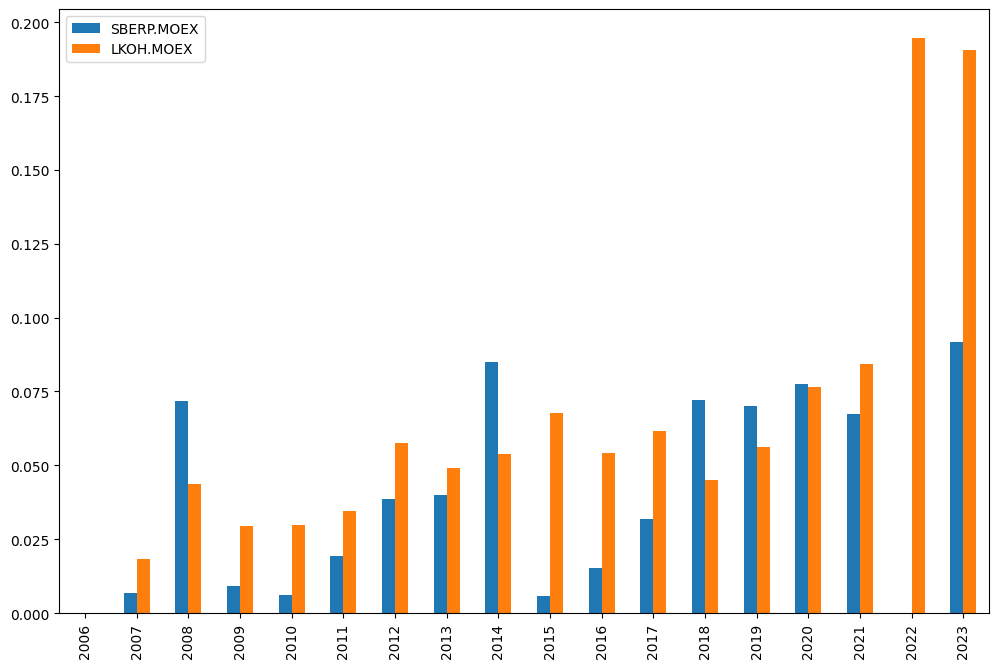

In [12]:
al.dividend_yield_annual.plot(kind="bar")

In [13]:
al.get_dividend_mean_growth_rate()

SBERP.MOEX   -1.00000
LKOH.MOEX     0.28652
dtype: float64

In [14]:
al.get_dividend_mean_yield(10)

SBERP.MOEX   0.05166
LKOH.MOEX    0.08849
dtype: float64

## Plot Wealth

In [15]:
def plot_wealth(
    al: object,
    first_date: str,
    last_date: str,
    legend: list,
    title: str = None,
    logy: bool = False,
    figsize: list = [12, 10],
):
    fig, ax = plt.subplots(figsize=figsize)
    # fig.subplots_adjust(bottom=0.2, top=1.5)
    first_date_dt = pd.to_datetime(first_date)
    last_date_dt = pd.to_datetime(last_date)

    wealth = al.wealth_indexes
    wealth = wealth.loc[first_date:last_date, :]
    index = wealth.index.to_timestamp()
    min_value = wealth.to_numpy().min()
    for i, asset in enumerate(wealth):
        if i == len(wealth.columns) - 1:
            # Inflation is in the last column
            continue
        ax.plot(index, wealth[asset], linewidth=2)
    ax.fill_between(index, min_value, wealth.iloc[:, -1], facecolor="grey", alpha=0.2, label="Инфляция")

    # Log scale
    y_scale = "log" if logy else "linear"
    ax.set_yscale(y_scale)

    # границы графика
    ax.set_xlim(first_date_dt, last_date_dt + pd.DateOffset(months=0))
    ax.set_ylim(bottom=min_value)

    # регулирования надписей оси Х
    years = mdates.YearLocator()  # ежегодный формат
    years_fmt = mdates.DateFormatter("%Y")
    # назначение формата надписей
    ax.xaxis.set_major_locator(years)
    ax.xaxis.set_major_formatter(years_fmt)

    ax.legend(legend + ["Инфляция"], loc="upper left")
    ax.set_title(title)

    # ax.set_ylabel('Инфляция за 12 месяцев, %')

In [16]:
stocks = ok.AssetList(["MCFTR.INDX", "SP500TR.INDX"], ccy="RUB", inflation=False)
stocks

assets           [MCFTR.INDX, SP500TR.INDX]
currency                                RUB
first_date                          1997-10
last_date                           2024-02
period_length            26 years, 5 months
inflation                              None
dtype: object

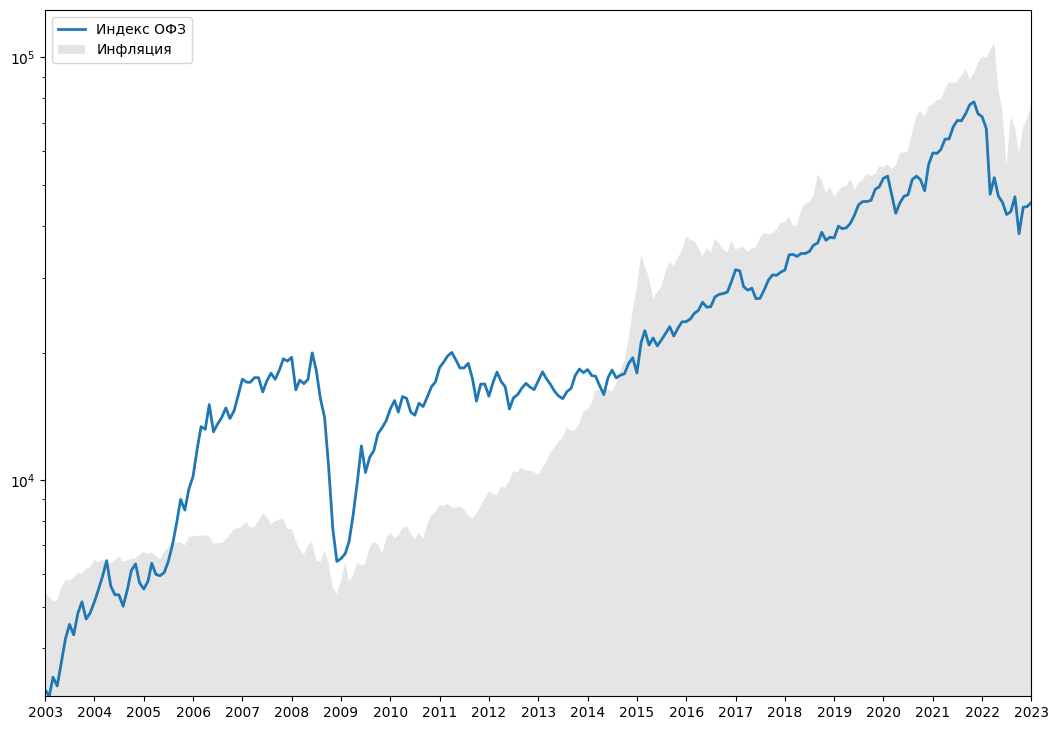

In [17]:
plot_wealth(
    al=stocks, first_date="2003-01", figsize=(14 / 1.1, 10 / 1.1), last_date="2023-01", legend=["Индекс ОФЗ"], logy=True
)